# Devoir 6 : TALN

In [1]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix

from nlp_code import *
%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package punkt to /home/simon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/simon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/simon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Ce devoir a pour objectif de vous aider à comprendre certains des fondamentaux du Traitement Automatique du Langage Naturel (TALN) qui ont été étudiés dans le cours. Vous devrez compléter le code de base trouvé dans le fichier "nlp_code.py", effectuer certaines tâches dans ce notebook Jupyter et rédiger un rapport sur certaines des sections.


## Tâche 1 : Préparation des données et Exploration initiale

1-. Nous allons travailler sur l'ensemble de données "Critiques de films IMDb".

2-. En utilisant pandas :

> 2.1-. Nous chargerons l'ensemble de données dans le notebook Jupyter.
  
3-. Nous examinerons l'ensemble de données et vérifierons les points suivants (**Incluez les réponses pour les points suivants sous le titre "Section 1 - Point 3"**) :
* Nombre de points de données (?)
* Combien de valeurs uniques contient notre colonne cible ?
* Contient-elle des valeurs NaN ?
* Y a-t-il des critiques en double ? (si vous trouvez des lignes en double, combien de doublons avez-vous trouvés ?)


In [2]:
# Ne modifiez pas cette cellule
np.random.seed(42)

In [3]:
# Chemin vers notre ensemble de données :
fichier = 'data/IMDB_dataset.csv'

In [4]:
# Chargement de notre ensemble de données :
df = pd.read_csv(fichier)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


#### Nombre de points

In [5]:
len(df)

50000

#### Valeurs uniques de la colonne vible

In [6]:
df["sentiment"].unique()

array(['positive', 'negative'], dtype=object)

#### Nombre de NaN

In [7]:
df["review"].isna().sum()

0

#### Nombre de doublons

In [8]:
sized_df = df.groupby(by = "review", as_index = False).size()
print(sized_df["size"].unique())
len(df)-len(sized_df)

[1 2 4 3 5]


418

Si vous avez trouvé des doublons, supprimez-les de l'ensemble de données.

In [9]:
df.drop_duplicates(inplace = True)

Assurez-vous que nous traitons des critiques uniques.

In [10]:
print(len(df))
df.head()

49582


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Tâche 2 : Prétraitement des données

Dans cette tâche, nous préparerons notre ensemble de données pour une analyse exploratoire des données (AED/EDA (Anglais)).

1-. Complétez la fonction `preprocess_text` contenue dans `nlp_code.py`. Cette fonction prend une critique (chaîne de caractères) en entrée et devrait renvoyer une version propre de la critique sans : balises HTML, signes de ponctuation, stopwords courants et jetons vides. De plus, tous les mots doivent être en minuscules et lemmatisés.

2-. Créez un nouveau DataFrame appelé `clean_df` avec les colonnes `clean_review` et `sentiment`. Vous devriez appliquer la fonction `preprocess_text` à toutes les critiques originales et stocker les critiques nettoyées dans la colonne `clean_review`.

3-. Affichez dans une nouvelle cellule les 5 premiers éléments de notre nouveau DataFrame.

In [11]:
# Complétez les points 2 et 3 dans les cellules suivantes.

In [12]:
clean_df = df.copy()
clean_df["clean_review"] = clean_df["review"].map(preprocess_text)
clean_df.drop(columns = ["review"], inplace = True)

In [13]:
clean_df.head(5)

,sentiment,clean_review
0,positive,one reviewer mentioned watching 1 oz episode '...
1,positive,wonderful little production filming technique ...
2,positive,thought wonderful way spend time hot summer we...
3,negative,basically 's family little boy jake think 's z...
4,positive,petter mattei 's love time money visually stun...


In [38]:
print(preprocess_text(df["review"][0]))

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.  The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.  It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.  I would say the main appeal of the show is due to the fact that it goes where other sho

[nltk_data] Downloading package punkt to /home/simon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/simon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/simon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Tâche 3 : Analyse exploratoire des données (AED)

Dans cette section, nous réaliserons une EDA de base sur notre ensemble de données prétraité. Cela va nous aider à répondre aux questions suivantes :

* Comment les valeurs cibles sont-elles distribuées ? Avons-nous un ensemble de données presque équilibré ?
* Toutes les critiques ont-elles la même longueur ?
* Quelle est la longueur moyenne des séquences ?
* Quels sont les 20 mots les plus fréquents ?
* Quels sont les 20 mots les moins fréquents ?
* Après avoir effectué une AED, pensez-vous qu'il sera facile de classifier ces critiques ? Pourquoi oui ? Pourquoi non ? **[Discussion]**

1-. En utilisant matplotlib et seaborn (utilisez un count plot), tracez le décompte total des étiquettes cibles. Nous voulons voir s'ils sont à peu près équilibrés ou si nous avons affaire à un ensemble de données fortement déséquilibré. Vous pouvez également appuyer votre analyse en calculant les décomptes pour chaque étiquette.

2-. En utilisant matplotlib et seaborn (utilisez un histogramme), tracez les longueurs des séquences de nos critiques (celles stockées dans la colonne `clean_review`). Pour ce faire, vous devrez compléter la fonction `review_lengths` dans le fichier `nlp_code.py`. Cette fonction prend la colonne `clean_review` comme entrée et renvoie une pd.Series des longueurs de séquence de chaque critique prétraitée.

3-. En utilisant matplotlib et seaborn (utilisez un histogramme, trouvez une orientation qui nous aide à voir clairement la différence de fréquences), tracez les 20 mots les plus fréquents, puis tracez les 20 mots les moins fréquents. Pour ce faire, vous devrez compléter la fonction `word_frequency` dans le fichier `nlp_code.py`. Cette fonction prend la colonne `clean_review` comme entrée et renvoie une pd.Series avec la longueur de séquence de chaque critique prétraitée.

**Dans votre rapport, vous devez répondre aux questions de la cellule précédente et les étayer avec vos graphiques générés et votre analyse. Développez suffisamment la question pour montrer votre compréhension de l'ensemble de données.**

### 3.1 Distribution des valeurs cibles

<Axes: xlabel='count', ylabel='sentiment'>

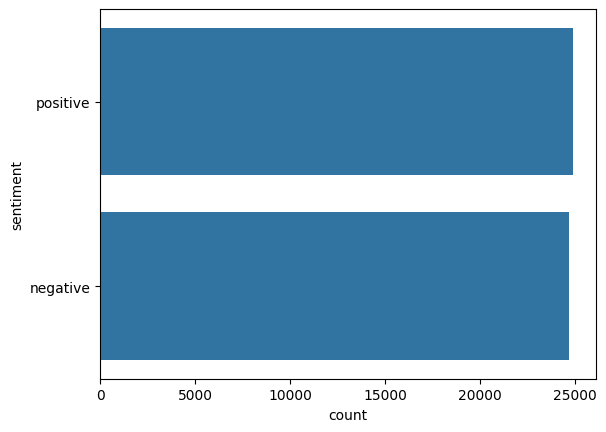

In [15]:
sns.countplot(data = clean_df["sentiment"])

### 3.2 Longueur de séquence

In [16]:
lengths = review_lengths(clean_df["clean_review"])

[Text(0.5, 0, 'Number of words'),
 Text(0.5, 1.0, 'Frequency of length of reviews')]

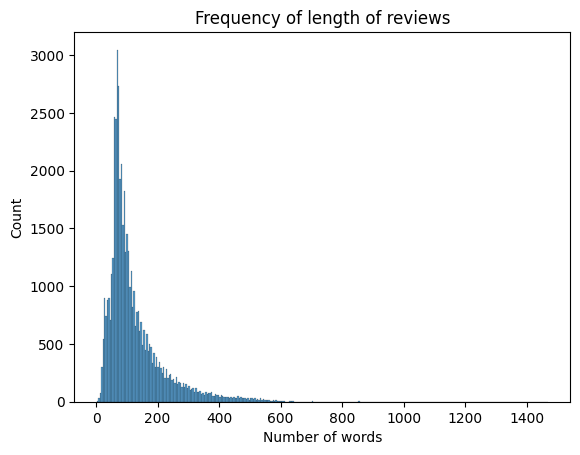

In [17]:
ax = sns.histplot(lengths)
ax.set(xlabel='Number of words', title = 'Frequency of length of reviews')

### 3.3 Fréquence des mots

In [18]:
freq = word_frequency(clean_df["clean_review"])
df_40 = pd.DataFrame(freq.iloc[np.r_[0:20, -21:-1]])
df_40.reset_index(inplace = True)

In [19]:
df_40.head()

,index,0
0,'s,121667
1,movie,102451
2,film,92781
3,n't,65903
4,one,55005


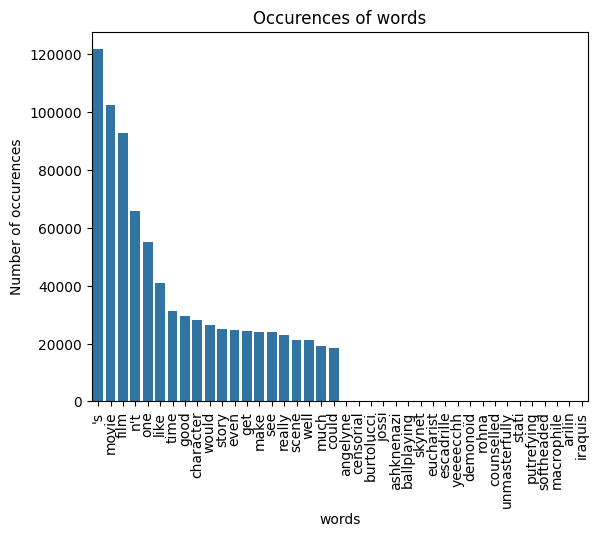

In [20]:
ax = sns.barplot(df_40, x ="index",  y= 0)
ax.set(ylabel='Number of occurences', title = "Occurences of words", xlabel = 'words')
plt.xticks(rotation=90)
plt.show()

**Que se passe-t-il si vous souhaitez identifier les bigrammes ? Vous devriez trouver toutes les paires de mots possibles, puis compter les paires de mots uniques. Exemple : `C'est un exemple de phrase pour extraire des bigrammes.`, alors nos bigrammes seraient : `('C'est', 'un'), ('un', 'exemple'), ('exemple', 'de'),('de', 'phrase'),('phrase', 'pour'),('pour', 'extraire'),('extraire', 'des'),('des', 'bigrammes'),('bigrammes', '.')`. Comme nous n'avons qu'une seule phrase et qu'ils sont tous uniques, leur compte serait de 1. Laissez-moi vous montrer comment cela fonctionnerait pour un petit échantillon de notre ensemble de données.**

In [21]:
from nltk import bigrams
from nltk.tokenize import word_tokenize
from collections import Counter

# Un petit exemple de notre ensemble de données propre avec 100 exemples :
movie_reviews = clean_df["clean_review"][0:100]

# Initialiser une liste vide pour stocker les bigrammes trouvés
all_bigrams = []

# Parcourir chaque critique de film
for review in movie_reviews:
    # Tokeniser le texte
    tokens = word_tokenize(review)

    # Créer des bigrammes pour chaque critique
    bi_grams = list(bigrams(tokens))

    # Étendre la liste de tous les bigrammes
    all_bigrams.extend(bi_grams)

# Compter les occurrences de chaque bigramme à travers toutes les critiques
bigram_counts = Counter(all_bigrams)

# Afficher les résultats
print(bigram_counts)

Counter({('ca', "n't"): 18, ('b', 'movie'): 12, ("n't", 'even'): 10, ("'ve", 'seen'): 8, ('3', '10'): 7, ('film', "'s"): 7, ('good', 'movie'): 7, ('worst', 'movie'): 7, ('wait', 'wait'): 7, ('would', "n't"): 6, ('serial', 'killer'): 6, ('movie', "n't"): 6, ("n't", 'get'): 6, ('cold', 'mountain'): 6, ('even', 'though'): 6, ('hitchcock', "'s"): 6, ('real', 'life'): 5, ('new', 'york'): 5, ('ever', 'seen'): 5, ('movie', 'like'): 5, ("n't", 'want'): 5, ('di', 'girolamo'): 5, ('movie', 'ever'): 5, ('bad', 'movie'): 5, ('number', '23'): 5, ('could', "n't"): 4, ('think', "'s"): 4, ('wan', 'na'): 4, ('waste', 'time'): 4, ("'s", 'still'): 4, ('one', 'worst'): 4, ('year', 'old'): 4, ('see', 'movie'): 4, ('special', 'effect'): 4, ("'s", 'movie'): 4, ("n't", 'much'): 4, ("n't", 'help'): 4, ('movie', "'s"): 4, ('wo', "n't"): 4, ('main', 'character'): 4, ('many', 'time'): 4, ('mumbai', 'police'): 4, ('half', 'film'): 4, ('le', 'conseguenze'): 4, ('conseguenze', "dell'amore"): 4, ("n't", 'see'): 4, ('

# Tâche 4 : Extraction des caractéristiques et préparation de la cible

Dans cette tâche, nous allons préparer nos données textuelles prétraitées pour les rendre utiles à notre modèle de classification.

1-. Nous devons encoder la colonne "sentiment" de notre ensemble de données en valeurs numériques utilisables par le modèle. Vous compléterez la fonction `encode_sentiment` trouvée dans le fichier `nlp_code.py`. Cette fonction prendra notre dataframe avec les colonnes `clean_review` et `sentiment` et renverra un nouveau dataframe avec la colonne `sentiment` encodée en positif = 1 et négatif = 0.
1-. We need to encode the "sentiment" column of our dataset into numerical values that can be used by the model. You will complete the `encode_sentiment` function found in the `nlp_code.py` file. This function will take our dataframe with the columns `clean_review` and `sentiment` and it will return a new dataframe with the `sentiment` column encoded as positive = 1 and negative = 0.

In [22]:
# Ne pas modifier ceci
new_df = encode_sentiment(clean_df)

> 1.1-. Dans la cellule de code suivante, affichez les 5 premières lignes du nouveau jeu de données.

In [23]:
print(new_df["sentiment"].unique())
new_df.head(5)

[1 0]


,sentiment,clean_review
0,1,one reviewer mentioned watching 1 oz episode '...
1,1,wonderful little production filming technique ...
2,1,thought wonderful way spend time hot summer we...
3,0,basically 's family little boy jake think 's z...
4,1,petter mattei 's love time money visually stun...


In [24]:
clean_df.head(5)

,sentiment,clean_review
0,positive,one reviewer mentioned watching 1 oz episode '...
1,positive,wonderful little production filming technique ...
2,positive,thought wonderful way spend time hot summer we...
3,negative,basically 's family little boy jake think 's z...
4,positive,petter mattei 's love time money visually stun...


Nous diviserons notre ensemble de données en un ensemble d'entraînement et un ensemble de test. Pour ce faire, nous utiliserons la bibliothèque scikit-learn pour cette partition. J'ai utilisé un test_size = 0.2 et un random_state = 42. 

**Vous devriez conserver cette division tout au long de l'ensemble de votre travail.**

In [25]:
# Ne pas modifier ceci
X = new_df['clean_review']
y = new_df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Dans la tâche 3 - point 2, je vous ai demandé de calculer la longueur de séquence pour nos critiques. Comme vous avez pu le constater, la longueur de séquence des critiques n'est pas la même dans l'ensemble de données/corpus. De nombreux modèles ML ont des exigences d'entrée de taille fixe, il est donc essentiel d'identifier une bonne longueur de séquence pour améliorer les performances du modèle.

Comme je l'ai expliqué au début de cette tâche, avant de commencer à entraîner notre modèle, nous devons obtenir une représentation numérique des mots contenus dans nos critiques. Une façon de le faire, sans avoir à prendre en compte les longueurs de séquence, est d'utiliser le "TfidfVectorizer" de scikit-learn. Tf-idf signifie fréquence du terme multipliée par la fréquence inverse du document. Cette représentation numérique pénalise davantage les mots fréquents et donne plus de pertinence aux mots moins fréquents. Vous pouvez trouver plus d'informations sur cette méthode dans la documentation de scikit-learn : https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer

Nous utiliserons le "TfidVectorizer" de scikit-learn avec les paramètres par défaut, pour obtenir une matrice de caractéristiques TF-IDF. Nous sauvegarderons les données transformées dans de nouvelles variables appelées X_train_tfidf et X_test_tfidf.

Dans votre rapport, vous devrez :

* Expliquer les inconvénients de l'utilisation de cette méthode. **[Discussion]**

* Fournir une méthode alternative que nous aurions pu utiliser pour trouver une meilleure représentation numérique des mots présents dans notre corpus. (Pourquoi pensez-vous que cela pourrait fonctionner mieux ?) **[Discussion]**


In [26]:
# Ne pas modifier ceci
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

Maintenant que nous avons effectué notre extraction de caractéristiques et encodé nos étiquettes cibles, nous pouvons entraîner un modèle et commencer à prédire le sentiment des critiques.

Nous utiliserons un modèle simple de `Naïve Bayes` pour comprendre à quel point il est facile/difficile de prédire le sentiment de nos critiques de films.

1-. Nous utiliserons le modèle "MultinomialNB" de scikit-learn pour entraîner un modèle de Naïve Bayes sur les données `X_train_tfidf` et les cibles `y_train`. Nous utiliserons les paramètres par défaut de ce modèle.

In [27]:
# Ne pas modifier ceci
naive_bayes_classifier = MultinomialNB()

naive_bayes_classifier.fit(X_train_tfidf, y_train)

MultinomialNB()

2-. Maintenant, nous prédirons le sentiment de nos critiques de l'ensemble d'entraînement.

In [28]:
# Ne pas modifier ceci
y_pred = naive_bayes_classifier.predict(X_test_tfidf)

3-. En utilisant scikit-learn, calculez l'exactitude de notre modèle sur l'ensemble de test et affichez le rapport de classification.

In [29]:
metrics.accuracy_score(y_test,y_pred)

0.8655843501058788

4-. En utilisant scikit-learn, affichez la matrice de confusion de notre modèle sous forme de heatmap.

array([[4310,  629],
       [ 704, 4274]])

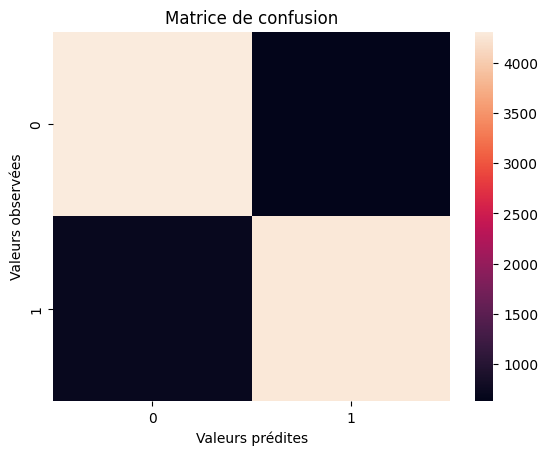

In [30]:
data = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(data)
ax.set(title=  "Matrice de confusion", ylabel = "Valeurs observées", xlabel = "Valeurs prédites")
plt.plot()
data

Nous pouvons visualiser les critiques mal classées. Sont-elles particulièrement difficiles à classifier comme positives ou négatives ? (Pas besoin de répondre à cela :) )

In [31]:
# Ne pas modifier ceci
# Identifier les critiques mal classées
indices_critiques_mal_classees = (y_test != y_pred)
critiques_mal_classees = X_test[indices_critiques_mal_classees]
etiquettes_reelles = y_test[indices_critiques_mal_classees]
etiquettes_predites = y_pred[indices_critiques_mal_classees]

# Afficher les critiques mal classées avec les étiquettes réelles et prédites
for critique, etiquette_reelle, etiquette_predite in zip(critiques_mal_classees, etiquettes_reelles, etiquettes_predites):
    print(f"Critique : {critique}\nÉtiquette Réelle : {etiquette_reelle}\nÉtiquette Prédite : {etiquette_predite}\n")


Critique : national treasure 2004 thoroughly misguided hodge podge plot entanglement borrow nearly every cloak dagger government conspiracy cliché ever written film star nicholas cage benjamin franklin gate precious ask seemingly normal fellow reason lineage like minded misguided fortune hunter decides steal 'national treasure hidden united state founding father bit subtext background play laughably unintentionally like indiana jones meet patriot film degenerate one misguided whimsy another attempting create 'stanley goodspeed regurgitation nicholas cage launch whole convoluted mess forward series high octane disconnected misadventure relevancy logic george washington motley crew patriot burying king 's ransom someplace native soil going meticulous plan leaving clue scattered throughout u currency art work something director jon turteltaub never quite get around explaining could n't washington found better usage wealth start country hence left mystery built top enigma already shaky gro

5-. Pour nous aider à expliquer les prédictions faites par notre modèle, nous allons explorer un nouvel outil d'explicabilité des modèles appelé `LIME`. LIME (Local Interpretable Model-agnostic Explanations) est une technique utilisée pour expliquer les prédictions des modèles d'apprentissage automatique en les approximant avec un modèle localement interprétable. Pour ce faire, vous devrez compléter la fonction `explain_prediction` dans `nlp_code.py`. **Remarque : LIME est un outil puissant pour générer des explications locales, mais gardez à l'esprit qu'il fournit une approximation du processus de prise de décision du modèle. Il perturbe les données d'entrée pour comprendre comment le modèle se comporte localement, et les explications ne représentent pas toujours parfaitement le comportement global du modèle.**

In [46]:
# Ne pas modifier ceci
# Afficher les informations
# Obtenir les indices de l'ensemble de test
indices_ensemble_test = X_test.index

# Trouver l'indice du premier élément dans l'ensemble de test en accédant au premier élément de indices_ensemble_test
idx = indices_ensemble_test[0]
exp, prob = explain_instance(tfidf_vectorizer, naive_bayes_classifier, X_test, idx=idx, num_features=10)
noms_classes = ['négatif', 'positif']
print('Identifiant du document : %d' % idx)
print('Probabilité (Positif) =', prob)
print('Classe réelle : %s' % noms_classes[y_test[idx]])

# Afficher l'explication dans le notebook
exp.show_in_notebook(text=True)

[nltk_data] Downloading package punkt to /home/simon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/simon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/simon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


ValueError: Iterable over raw text documents expected, string object received.

**Dans votre rapport, ajoutez la visualisation obtenue et donnez une interprétation de celle-ci. [Discussion]**

# Tâche 5 : Exploration d'un modèle Transformer

Dans cette section, je voudrais que vous `essayiez de` surpasser notre modèle précédent avec un modèle beaucoup plus complexe. Vous utiliserez un modèle transformateur appelé `distilBERT` pour cela (vous pouvez utiliser la bibliothèque HuggingFace pour l'implémenter). Dans votre rapport, je voudrais que vous :

1-. Mettez en œuvre le modèle distilBERT, entraînez-le et évaluez-le sur le même jeu d'entraînement que notre classifieur Naïve Bayes. Vous pouvez sauvegarder les ensembles de données prétraités sous forme de fichiers csv (avec les noms de colonnes text et labels) puis les charger à l'aide de la méthode load_dataset de la bibliothèque datasets. Vous devez faire attention au formatage des entrées pour ce modèle transformateur (son nom est : distilbert-base-uncased).

2-. Explorez 2 façons différentes d'ajuster le modèle (# epochs, learning rate, weight decay, etc.) pour améliorer les performances de classification (incluez le(s) tableau(x) des résultats obtenus par rapport aux approches explorées, indiquez la configuration qui a produit les meilleurs résultats). Je veux connaître en détail la méthodologie que vous avez suivie pour améliorer les performances du modèle. Par conséquent, j'attends une discussion raisonnable sur les approches que vous avez prises (je retirerai des points pour les changements aléatoires des hyperparamètres du modèle). **[Discussion]**

3-. Vous devrez inclure dans votre rapport votre précision("accuracy" et "precission"), rappel et scores F1 (discutez-les et comparez-les). De plus, vous devez inclure l'image de votre matrice de confusion sous forme de heatmap (meilleur modèle). Rapportez si les résultats obtenus sont bien meilleurs que ceux obtenus avec le classifieur Naïve Bayes. (Soutenez vos commentaires en comparant les scores et les heatmaps, j'attends une bonne quantité de discussion). **[Discussion]**


**Avertissements : Cette partie de l'assignation doit être effectuée dans Google Colab avec un environnement GPU, car les LLM sont difficiles à entraîner sur un ordinateur portable ou un PC classique (si vous avez un ordinateur puissant, n'hésitez pas à essayer). Je ne vous demande pas de vous acharner à améliorer de manière extrême un modèle qui ne s'améliore pas ou à suraméliorer un modèle qui fonctionne déjà mieux que le Naïve Bayes (concentrez vos efforts dans les limites des exigences attendues). Mon objectif est de vous donner de l'expérience dans l'entraînement de ce type de modèle et de vous faire remarquer combien de temps cela prend pour les entraîner. Parfois, facile, rapide et explicable/interprétable est meilleur que complexe, lent et difficile à expliquer/interpréter.**

Voici un [tutoriel](https://huggingface.co/blog/sentiment-analysis-python)

In [ ]:
# Your code here